# Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Предварительный анализ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.dummy import DummyRegressor
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler 

In [2]:
data_contract = pd.read_csv('/datasets/final_provider/contract.csv')
data_personal = pd.read_csv('/datasets/final_provider/personal.csv')
data_internet = pd.read_csv('/datasets/final_provider/internet.csv')
data_phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
data_contract.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
data_contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [6]:
data_contract['BeginDate'] = pd.to_datetime(data_contract['BeginDate'], format='%Y-%m-%d')

In [7]:
data_contract['year_of_begindate'] = pd.DatetimeIndex(data_contract['BeginDate']).year
data_contract['month_of_begindate'] = pd.DatetimeIndex(data_contract['BeginDate']).month

Text(0, 0.5, 'Количество клиентов')

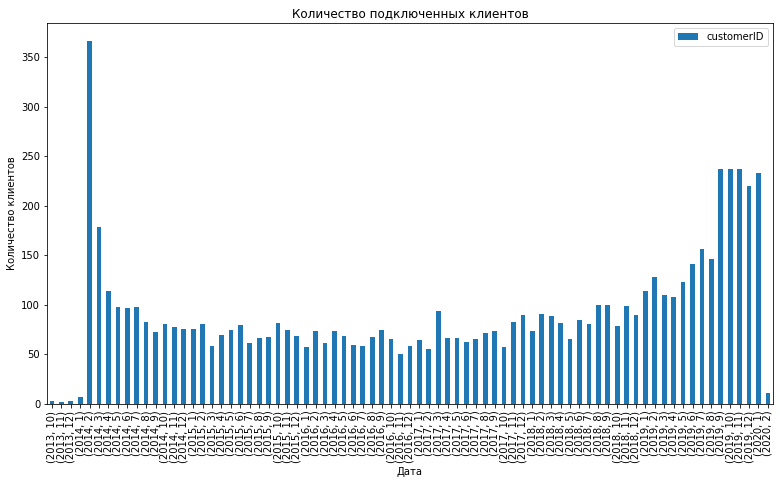

In [8]:
data_contract.pivot_table(index = ['year_of_begindate', 'month_of_begindate'], values = 'customerID', aggfunc = 'count').plot(kind = 'bar', figsize = (13, 7))
plt.title('Количество подключенных клиентов')
plt.xlabel("Дата")
plt.ylabel("Количество клиентов")

In [9]:
data_enddate = data_contract.query('EndDate != "No"')
data_enddate.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,year_of_begindate,month_of_begindate
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,2019,10
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,2019,9
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5,2019,3
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,2017,7
13,0280-XJGEX,2015-09-01,2019-10-01 00:00:00,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,2015,9


In [10]:
data_enddate[['End_Date','End_Date_H']] = data_enddate.EndDate.str.split(expand=True)
data_enddate.head(5)

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,year_of_begindate,month_of_begindate,End_Date,End_Date_H
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,2019,10,2019-12-01,00:00:00
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,2019,9,2019-11-01,00:00:00
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5,2019,3,2019-11-01,00:00:00
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,2017,7,2019-11-01,00:00:00
13,0280-XJGEX,2015-09-01,2019-10-01 00:00:00,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,2015,9,2019-10-01,00:00:00


In [11]:
data_enddate['End_Date'] = pd.to_datetime(data_enddate['End_Date'], format='%Y-%m-%d')

/tmp/ipykernel_84/2530042535.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_enddate['End_Date'] = pd.to_datetime(data_enddate['End_Date'], format='%Y-%m-%d')


In [12]:
data_enddate['year_of_enddate'] = pd.DatetimeIndex(data_enddate['EndDate']).year
data_enddate['month_of_enddate'] = pd.DatetimeIndex(data_enddate['EndDate']).month
data_enddate.head(5)

/tmp/ipykernel_84/2029039279.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_enddate['year_of_enddate'] = pd.DatetimeIndex(data_enddate['EndDate']).year
/tmp/ipykernel_84/2029039279.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_enddate['month_of_enddate'] = pd.DatetimeIndex(data_enddate['EndDate']).month


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,year_of_begindate,month_of_begindate,End_Date,End_Date_H,year_of_enddate,month_of_enddate
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,2019,10,2019-12-01,00:00:00,2019,12
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,2019,9,2019-11-01,00:00:00,2019,11
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5,2019,3,2019-11-01,00:00:00,2019,11
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,2017,7,2019-11-01,00:00:00,2019,11
13,0280-XJGEX,2015-09-01,2019-10-01 00:00:00,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,2015,9,2019-10-01,00:00:00,2019,10


Text(0, 0.5, 'Количество клиентов')

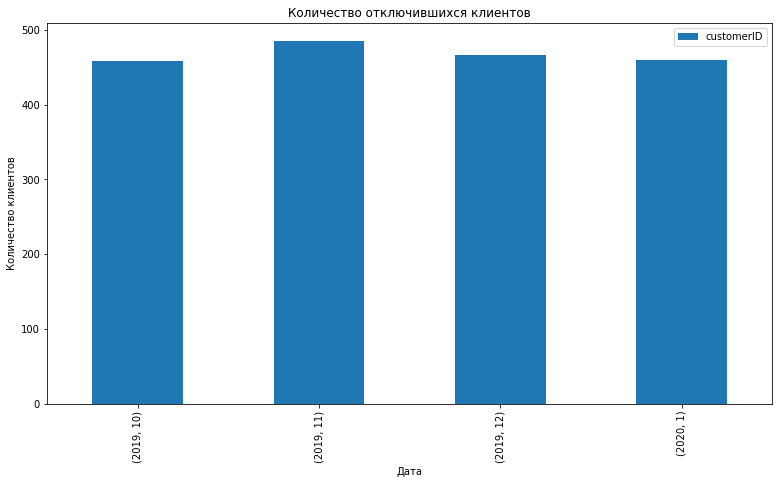

In [13]:
data_enddate.pivot_table(index = ['year_of_enddate', 'month_of_enddate'], values = 'customerID', aggfunc = 'count').plot(kind = 'bar', figsize = (13, 7))
plt.title('Количество отключившихся клиентов')
plt.xlabel("Дата")
plt.ylabel("Количество клиентов")

In [14]:
data_contract['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

In [15]:
data_contract['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

In [16]:
data_contract['PaperlessBilling'].value_counts()

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

In [17]:
data_contract['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

<AxesSubplot:>

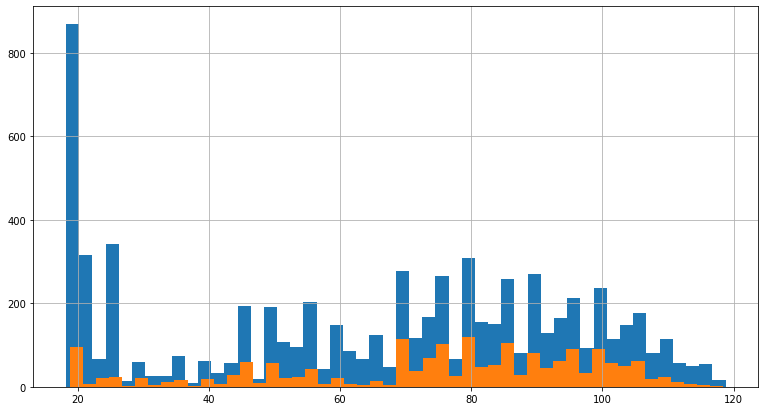

In [18]:
data_contract['MonthlyCharges'].hist(bins = 50, figsize = (13, 7))
data_enddate['MonthlyCharges'].hist(bins = 50, figsize = (13, 7))

In [19]:
data_personal.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [20]:
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [21]:
data_personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [22]:
data_personal['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In [23]:
data_personal['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

In [24]:
data_internet.head(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [25]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [26]:
data_internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,3780-YVMFA,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [27]:
data_phone.head(5)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [28]:
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [29]:
data_phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,2612-RRIDN,No
freq,1,3390


# План:

0) Необходимо объединить все данные в одну таблицу.

1) Считаю что нужно оставить информацию о подключении и отключении, только преобразовать ее в столбцы "сколько месяцев подключен" и "отключился" в бинарном формате как целевой признак. Также необходимо оставить ежемесячную плату. Сумма оплат за все время на мой взгляд будет лишним, если мы не знаем динамику по месяцам. Оставлю все данные характеризующие пользователя. 

2) Оставлю сервисы для более подробного исследования, возможно пользователи уходят поскольку какой то определенный сервис плох.

3) Далее нужно обработать данные, к счастью пропусков у нас нет, однако для обучения модели нужно привести данные в порядок, например присвоить числовым столбцам тип int вместо object. Также нужно привести данные с ограниченным кол-вом вариантов к числовому виду с помощью get_dummies (1 и 0 вместо yes no).

3) Проверить корреляцию между данными и убрать лишнее если у каких то столбцов сильная зависимость.

4) Переходим к обучению модели, поскольку нам одинаково важно найти всех пользователей собирающихся уйти и не направлять ошибочно промокоды тем кто уходить не хочет, воспользуемся метриками accuracy и auc-roc.

## Предобработка данных

In [30]:
data_1 = data_contract.merge(data_personal, on='customerID', how='left')
data_2 = data_1.merge(data_internet, on='customerID', how='left')
full_df = data_2.merge(data_phone, on='customerID', how='left')
full_df.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,year_of_begindate,month_of_begindate,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,2020,1,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,2017,4,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,2019,10,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,2016,5,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,2019,9,...,No,No,Fiber optic,No,No,No,No,No,No,No


In [31]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customerID          7043 non-null   object        
 1   BeginDate           7043 non-null   datetime64[ns]
 2   EndDate             7043 non-null   object        
 3   Type                7043 non-null   object        
 4   PaperlessBilling    7043 non-null   object        
 5   PaymentMethod       7043 non-null   object        
 6   MonthlyCharges      7043 non-null   float64       
 7   TotalCharges        7043 non-null   object        
 8   year_of_begindate   7043 non-null   int64         
 9   month_of_begindate  7043 non-null   int64         
 10  gender              7043 non-null   object        
 11  SeniorCitizen       7043 non-null   int64         
 12  Partner             7043 non-null   object        
 13  Dependents          7043 non-null   object      

Проверим нет ли таких пользователей у кого нет информации ни по интернет услугам ни по телефонии, если такие есть - значит исключим их из данных. Отсутствие в одной из таблиц означает что не все пользуются интернетом и не все пользуются телефоном.
Остальные пропуски заполним как отсутствие услуги и выведем новый столбец с 3 категориями клиентов 1) кто пользуется только телефоном, 2) кто пользуется только интернетом, 3) кто использует обе услуги.

In [32]:
full_df.query('MultipleLines.isna()').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 0 to 7040
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customerID          682 non-null    object        
 1   BeginDate           682 non-null    datetime64[ns]
 2   EndDate             682 non-null    object        
 3   Type                682 non-null    object        
 4   PaperlessBilling    682 non-null    object        
 5   PaymentMethod       682 non-null    object        
 6   MonthlyCharges      682 non-null    float64       
 7   TotalCharges        682 non-null    object        
 8   year_of_begindate   682 non-null    int64         
 9   month_of_begindate  682 non-null    int64         
 10  gender              682 non-null    object        
 11  SeniorCitizen       682 non-null    int64         
 12  Partner             682 non-null    object        
 13  Dependents          682 non-null    object       

In [33]:
full_df.loc[full_df.query('MultipleLines.isna()').index, 'Services'] = 'internet only'
full_df.loc[full_df.query('InternetService.isna()').index, 'Services'] = 'phone only'
full_df['Services'] = full_df['Services'].fillna('internet and phone')
full_df.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,year_of_begindate,month_of_begindate,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Services
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,2020,1,...,No,DSL,No,Yes,No,No,No,No,NaN,internet only
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,2017,4,...,No,DSL,Yes,No,Yes,No,No,No,No,internet and phone
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,2019,10,...,No,DSL,Yes,Yes,No,No,No,No,No,internet and phone
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,2016,5,...,No,DSL,Yes,No,Yes,Yes,No,No,NaN,internet only
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,2019,9,...,No,Fiber optic,No,No,No,No,No,No,No,internet and phone
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5,2019,3,...,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,internet and phone
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,2018,4,...,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,internet and phone
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9,2019,4,...,No,DSL,Yes,No,No,No,No,No,NaN,internet only
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,2017,7,...,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,internet and phone
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,2014,12,...,Yes,DSL,Yes,Yes,No,No,No,No,No,internet and phone


In [34]:
full_df['Services'].value_counts()

internet and phone    4835
phone only            1526
internet only          682
Name: Services, dtype: int64

In [35]:
full_df = full_df.fillna('No')
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customerID          7043 non-null   object        
 1   BeginDate           7043 non-null   datetime64[ns]
 2   EndDate             7043 non-null   object        
 3   Type                7043 non-null   object        
 4   PaperlessBilling    7043 non-null   object        
 5   PaymentMethod       7043 non-null   object        
 6   MonthlyCharges      7043 non-null   float64       
 7   TotalCharges        7043 non-null   object        
 8   year_of_begindate   7043 non-null   int64         
 9   month_of_begindate  7043 non-null   int64         
 10  gender              7043 non-null   object        
 11  SeniorCitizen       7043 non-null   int64         
 12  Partner             7043 non-null   object        
 13  Dependents          7043 non-null   object      

In [36]:
full_df.loc[full_df.query('EndDate == "2019-11-01 00:00:00"').index, 'EndDateNormalize'] = '2019-11-01'
full_df.loc[full_df.query('EndDate == "2019-12-01 00:00:00"').index, 'EndDateNormalize'] = '2019-12-01'
full_df.loc[full_df.query('EndDate == "2020-01-01 00:00:00"').index, 'EndDateNormalize'] = '2020-01-01'
full_df.loc[full_df.query('EndDate == "2019-10-01 00:00:00"').index, 'EndDateNormalize'] = '2019-10-01'
full_df.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,year_of_begindate,month_of_begindate,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Services,EndDateNormalize
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,2020,1,...,DSL,No,Yes,No,No,No,No,No,internet only,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,2017,4,...,DSL,Yes,No,Yes,No,No,No,No,internet and phone,NaN
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,2019,10,...,DSL,Yes,Yes,No,No,No,No,No,internet and phone,2019-12-01
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,2016,5,...,DSL,Yes,No,Yes,Yes,No,No,No,internet only,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,2019,9,...,Fiber optic,No,No,No,No,No,No,No,internet and phone,2019-11-01
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5,2019,3,...,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,internet and phone,2019-11-01
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,2018,4,...,Fiber optic,No,Yes,No,No,Yes,No,Yes,internet and phone,NaN
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9,2019,4,...,DSL,Yes,No,No,No,No,No,No,internet only,NaN
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,2017,7,...,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,internet and phone,2019-11-01
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,2014,12,...,DSL,Yes,Yes,No,No,No,No,No,internet and phone,NaN


In [37]:
full_df['EndDateNormalize'] = pd.to_datetime(full_df['EndDateNormalize'], format='%Y-%m-%d')
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customerID          7043 non-null   object        
 1   BeginDate           7043 non-null   datetime64[ns]
 2   EndDate             7043 non-null   object        
 3   Type                7043 non-null   object        
 4   PaperlessBilling    7043 non-null   object        
 5   PaymentMethod       7043 non-null   object        
 6   MonthlyCharges      7043 non-null   float64       
 7   TotalCharges        7043 non-null   object        
 8   year_of_begindate   7043 non-null   int64         
 9   month_of_begindate  7043 non-null   int64         
 10  gender              7043 non-null   object        
 11  SeniorCitizen       7043 non-null   int64         
 12  Partner             7043 non-null   object        
 13  Dependents          7043 non-null   object      

In [38]:
full_df.loc[full_df.query('EndDateNormalize.isna()').index, 'LostClients'] = 'No'
full_df['LostClients'] = full_df['LostClients'].fillna('Yes')
full_df.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,year_of_begindate,month_of_begindate,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Services,EndDateNormalize,LostClients
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,2020,1,...,No,Yes,No,No,No,No,No,internet only,NaT,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,2017,4,...,Yes,No,Yes,No,No,No,No,internet and phone,NaT,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,2019,10,...,Yes,Yes,No,No,No,No,No,internet and phone,2019-12-01,Yes
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,2016,5,...,Yes,No,Yes,Yes,No,No,No,internet only,NaT,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,2019,9,...,No,No,No,No,No,No,No,internet and phone,2019-11-01,Yes


In [39]:
full_df['EndDateNormalize'] = full_df['EndDateNormalize'].fillna('2020-02-01')
full_df['EndDateNormalize'] = pd.to_datetime(full_df['EndDateNormalize'], format='%Y-%m-%d')
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customerID          7043 non-null   object        
 1   BeginDate           7043 non-null   datetime64[ns]
 2   EndDate             7043 non-null   object        
 3   Type                7043 non-null   object        
 4   PaperlessBilling    7043 non-null   object        
 5   PaymentMethod       7043 non-null   object        
 6   MonthlyCharges      7043 non-null   float64       
 7   TotalCharges        7043 non-null   object        
 8   year_of_begindate   7043 non-null   int64         
 9   month_of_begindate  7043 non-null   int64         
 10  gender              7043 non-null   object        
 11  SeniorCitizen       7043 non-null   int64         
 12  Partner             7043 non-null   object        
 13  Dependents          7043 non-null   object      

In [40]:
full_df['Tenure'] = full_df['EndDateNormalize'] - full_df['BeginDate']
full_df['Tenure'] = full_df['Tenure'].dt.days
full_df.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,year_of_begindate,month_of_begindate,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Services,EndDateNormalize,LostClients,Tenure
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,2020,1,...,Yes,No,No,No,No,No,internet only,2020-02-01,No,31
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,2017,4,...,No,Yes,No,No,No,No,internet and phone,2020-02-01,No,1036
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,2019,10,...,Yes,No,No,No,No,No,internet and phone,2019-12-01,Yes,61
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,2016,5,...,No,Yes,Yes,No,No,No,internet only,2020-02-01,No,1371
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,2019,9,...,No,No,No,No,No,No,internet and phone,2019-11-01,Yes,61


Теперь необходимо удалить: customerID, BeginDate, EndDate, TotalCharges, year_of_begindate, month_of_begindate, EndDateNormalize. Далее проанализируем влияние оставшихся признаков с помощью коэффицента Пирсона.

In [41]:
full_df = full_df.drop(['customerID', 'BeginDate', 'EndDate', 'TotalCharges',
                        'year_of_begindate', 'month_of_begindate', 'EndDateNormalize'], axis = 1)
full_df.head(5)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Services,LostClients,Tenure
0,Month-to-month,Yes,Electronic check,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,internet only,No,31
1,One year,No,Mailed check,56.95,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,internet and phone,No,1036
2,Month-to-month,Yes,Mailed check,53.85,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,internet and phone,Yes,61
3,One year,No,Bank transfer (automatic),42.30,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,internet only,No,1371
4,Month-to-month,Yes,Electronic check,70.70,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,internet and phone,Yes,61


In [42]:
full_df['MonthlyCharges'] = full_df['MonthlyCharges'].astype('int64')
full_df['SeniorCitizen'] = full_df['SeniorCitizen'].astype('object')
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Type              7043 non-null   object
 1   PaperlessBilling  7043 non-null   object
 2   PaymentMethod     7043 non-null   object
 3   MonthlyCharges    7043 non-null   int64 
 4   gender            7043 non-null   object
 5   SeniorCitizen     7043 non-null   object
 6   Partner           7043 non-null   object
 7   Dependents        7043 non-null   object
 8   InternetService   7043 non-null   object
 9   OnlineSecurity    7043 non-null   object
 10  OnlineBackup      7043 non-null   object
 11  DeviceProtection  7043 non-null   object
 12  TechSupport       7043 non-null   object
 13  StreamingTV       7043 non-null   object
 14  StreamingMovies   7043 non-null   object
 15  MultipleLines     7043 non-null   object
 16  Services          7043 non-null   object
 17  LostClients   

Закодируем данные с помощью OHE и проверим корреляцию.

In [43]:
df_ohe = pd.get_dummies(full_df, drop_first=True)
df_ohe.head(5)

,MonthlyCharges,Tenure,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,SeniorCitizen_1,...,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,Services_internet only,Services_phone only,LostClients_Yes
0,29,31,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,56,1036,1,0,0,0,0,1,1,0,...,1,0,1,0,0,0,0,0,0,0
2,53,61,0,0,1,0,0,1,1,0,...,1,1,0,0,0,0,0,0,0,1
3,42,1371,1,0,0,0,0,0,1,0,...,1,0,1,1,0,0,0,1,0,0
4,70,61,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [44]:
df_ohe.corr()

,MonthlyCharges,Tenure,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,SeniorCitizen_1,...,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,Services_internet only,Services_phone only,LostClients_Yes
MonthlyCharges,1.000000,0.247771,0.004979,-0.074667,0.352138,0.030778,0.271746,-0.377487,-0.014892,0.220129,...,0.296631,0.441693,0.482646,0.338325,0.629562,0.627421,0.490505,-0.247277,-0.763512,0.193422
Tenure,0.247771,1.000000,0.202650,0.558544,0.006059,0.233032,-0.208465,-0.233755,0.005111,0.016514,...,0.327203,0.360238,0.360602,0.324238,0.279657,0.286007,0.331833,-0.008446,-0.038951,-0.352673
Type_One year,0.004979,0.202650,1.000000,-0.289510,-0.051391,0.067589,-0.109130,-0.000116,0.008026,-0.046262,...,0.100162,0.083722,0.102495,0.095775,0.061612,0.064926,-0.003794,0.002791,0.038004,-0.177820
Type_Two year,-0.074667,0.558544,-0.289510,1.000000,-0.147889,0.173265,-0.282138,-0.004705,-0.003695,-0.117000,...,0.191773,0.111400,0.165096,0.240824,0.072049,0.073960,0.106253,-0.003519,0.218278,-0.302253
PaperlessBilling_Yes,0.352138,0.006059,-0.051391,-0.147889,1.000000,-0.013589,0.208865,-0.205398,-0.011754,0.156530,...,-0.003636,0.126735,0.103797,0.037880,0.223841,0.211716,0.163530,-0.016505,-0.321013,0.191825
PaymentMethod_Credit card (automatic),0.030778,0.233032,0.067589,0.173265,-0.013589,1.000000,-0.373322,-0.286049,0.001215,-0.024135,...,0.115721,0.090785,0.111554,0.117272,0.040433,0.048575,0.060048,0.007721,0.001030,-0.134302
PaymentMethod_Electronic check,0.271746,-0.208465,-0.109130,-0.282138,0.208865,-0.373322,1.000000,-0.387372,0.000752,0.171718,...,-0.112338,-0.000408,-0.003351,-0.114839,0.144626,0.137966,0.083618,-0.003062,-0.284917,0.301919
PaymentMethod_Mailed check,-0.377487,-0.233755,-0.000116,-0.004705,-0.205398,-0.286049,-0.387372,1.000000,0.013744,-0.153477,...,-0.080798,-0.174164,-0.187373,-0.085509,-0.247742,-0.250595,-0.227206,0.003319,0.321361,-0.091683
gender_Male,-0.014892,0.005111,0.008026,-0.003695,-0.011754,0.001215,0.000752,0.013744,1.000000,-0.001874,...,-0.017021,-0.013773,-0.002105,-0.009212,-0.008393,-0.010487,-0.008414,0.006488,0.006026,-0.008612
SeniorCitizen_1,0.220129,0.016514,-0.046262,-0.117000,0.156530,-0.024135,0.171718,-0.153477,-0.001874,1.000000,...,-0.038653,0.066572,0.059428,-0.060625,0.105378,0.120176,0.142948,-0.008576,-0.182742,0.150889


## Обучение модели

In [45]:
features = df_ohe.drop('LostClients_Yes', axis = 1)
target = df_ohe['LostClients_Yes']
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                        test_size = 0.25, random_state=12345, stratify = target)

Мы разделили данные на обучающую и тестовую выборки, а теперь подберем лучшую модель и лучшие параметры для обучения. Я думаю нужно попробовать случайный лес, логистическую регрессию и градиентный бустинг.

In [46]:
best_model_1 = None
best_accuracy_1 = 0
best_roc_auc_1 = 0
best_est_1 = 0
best_depth_1 = 0
for est in range(10, 171, 10):
    for depth in range (1, 17):
        model_1 = RandomForestClassifier(random_state = 12345, n_estimators = est, max_depth = depth)
        model_1.fit(features_train, target_train) 
        predicted_1 = model_1.predict(features_test)
        accuracy_1 = accuracy_score(target_test, predicted_1)
        probabilities_valid_1 = model_1.predict_proba(features_test)
        probabilities_one_valid_1 = probabilities_valid_1[:, 1]
        roc_auc_1 = roc_auc_score(target_test, probabilities_one_valid_1)
        if best_roc_auc_1 < roc_auc_1:
            best_model_1 = model_1
            best_accuracy_1 = accuracy_1
            best_roc_auc_1 = roc_auc_1
            best_est_1 = est
            best_depth_1 = depth
print("Лучший roc_auc:", best_roc_auc_1, "Лучшая accuracy:", best_accuracy_1,
      "Количество деревьев:", best_est_1, "Максимальная глубина:", best_depth_1)

Лучший roc_auc: 0.8539652621719748 Лучшая accuracy: 0.8109028960817717 Количество деревьев: 90 Максимальная глубина: 8


In [47]:
model_2 = LogisticRegression(random_state = 12345, solver = 'liblinear')
model_2.fit(features_train, target_train)
predicted_2 = model_2.predict(features_test)
accuracy_2 = accuracy_score(target_test, predicted_2)
probabilities_valid_2 = model_2.predict_proba(features_test)
probabilities_one_valid_2 = probabilities_valid_2[:, 1]
roc_auc_2 = roc_auc_score(target_test, probabilities_one_valid_2)
print("roc_auc:", roc_auc_2, "accuracy:", accuracy_2)

roc_auc: 0.8374096885973475 accuracy: 0.8006814310051107


In [48]:
cat_features = ['Type_One year', 'Type_Two year', 'PaperlessBilling_Yes',
                'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'SeniorCitizen_1',
               'Partner_Yes', 'Dependents_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_Yes',
                'TechSupport_Yes', 'Services_phone only', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
                    'StreamingTV_Yes', 'StreamingMovies_Yes', 'MultipleLines_Yes', 'PaymentMethod_Mailed check',
                'gender_Male', 'Services_internet only']
model_3 = CatBoostClassifier(loss_function="Logloss", iterations=185, random_seed = 12345)
model_3.fit(features_train, target_train, cat_features=cat_features, verbose=10)
predicted_3 = model_3.predict(features_test)
accuracy_3 = accuracy_score(target_test, predicted_3)
probabilities_valid_3 = model_3.predict_proba(features_test)
probabilities_one_valid_3 = probabilities_valid_3[:, 1]
roc_auc_3 = roc_auc_score(target_test, probabilities_one_valid_3)
print("roc_auc:", roc_auc_3, "accuracy:", accuracy_3)

Learning rate set to 0.098531
0:	learn: 0.6250503	total: 70ms	remaining: 12.9s
10:	learn: 0.4185665	total: 102ms	remaining: 1.61s
20:	learn: 0.3819642	total: 134ms	remaining: 1.05s
30:	learn: 0.3659541	total: 166ms	remaining: 824ms
40:	learn: 0.3548692	total: 196ms	remaining: 688ms
50:	learn: 0.3451541	total: 228ms	remaining: 600ms
60:	learn: 0.3360137	total: 260ms	remaining: 529ms
70:	learn: 0.3275631	total: 293ms	remaining: 470ms
80:	learn: 0.3195020	total: 323ms	remaining: 415ms
90:	learn: 0.3137992	total: 353ms	remaining: 365ms
100:	learn: 0.3070630	total: 383ms	remaining: 319ms
110:	learn: 0.2999276	total: 414ms	remaining: 276ms
120:	learn: 0.2907281	total: 445ms	remaining: 236ms
130:	learn: 0.2821496	total: 477ms	remaining: 197ms
140:	learn: 0.2746784	total: 509ms	remaining: 159ms
150:	learn: 0.2686287	total: 541ms	remaining: 122ms
160:	learn: 0.2615034	total: 573ms	remaining: 85.4ms
170:	learn: 0.2566951	total: 605ms	remaining: 49.5ms
180:	learn: 0.2487436	total: 639ms	remaining

Проверим сделает ли балансировка классов модель точнее.

In [49]:
features_train_zero = features_train[target_train == 0]
features_train_one = features_train[target_train == 1]
target_train_zero = target_train[target_train == 0]
target_train_one = target_train[target_train == 1]

features_upsampled = pd.concat([features_train_zero] + [features_train_one] * 3)
target_upsampled = pd.concat([target_train_zero] + [target_train_one] * 3)

features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)

In [50]:
best_model_4 = None
best_accuracy_4 = 0
best_roc_auc_4 = 0
best_est_4 = 0
best_depth_4 = 0
for est in range(10, 171, 10):
    for depth in range (1, 17):
        model_4 = RandomForestClassifier(random_state = 12345, n_estimators = est, max_depth = depth)
        model_4.fit(features_upsampled, target_upsampled) 
        predicted_4 = model_4.predict(features_test)
        accuracy_4 = accuracy_score(target_test, predicted_4)
        probabilities_valid_4 = model_4.predict_proba(features_test)
        probabilities_one_valid_4 = probabilities_valid_4[:, 1]
        roc_auc_4 = roc_auc_score(target_test, probabilities_one_valid_4)
        if best_roc_auc_4 < roc_auc_4:
            best_model_4 = model_4
            best_accuracy_4 = accuracy_4
            best_roc_auc_4 = roc_auc_4
            best_est_4 = est
            best_depth_4 = depth
print("Лучший roc_auc:", best_roc_auc_4, "Лучшая accuracy:", best_accuracy_4,
      "Количество деревьев:", best_est_4, "Максимальная глубина:", best_depth_4)

Лучший roc_auc: 0.854676004223082 Лучшая accuracy: 0.7365133446905168 Количество деревьев: 20 Максимальная глубина: 7


In [51]:
model_5 = LogisticRegression(random_state = 12345, solver = 'liblinear')
model_5.fit(features_upsampled, target_upsampled)
predicted_5 = model_5.predict(features_test)
accuracy_5 = accuracy_score(target_test, predicted_5)
probabilities_valid_5 = model_5.predict_proba(features_test)
probabilities_one_valid_5 = probabilities_valid_5[:, 1]
roc_auc_5 = roc_auc_score(target_test, probabilities_one_valid_5)
print("roc_auc:", roc_auc_5, "accuracy:", accuracy_5)

roc_auc: 0.8367974079013996 accuracy: 0.7353776263486655


In [52]:
model_6 = CatBoostClassifier(loss_function="Logloss", iterations=185, random_seed = 12345)
model_6.fit(features_upsampled, target_upsampled, cat_features=cat_features, verbose=10)
predicted_6 = model_6.predict(features_test)
accuracy_6 = accuracy_score(target_test, predicted_6)
probabilities_valid_6 = model_6.predict_proba(features_test)
probabilities_one_valid_6 = probabilities_valid_6[:, 1]
roc_auc_6 = roc_auc_score(target_test, probabilities_one_valid_6)
print("roc_auc:", roc_auc_6, "accuracy:", accuracy_6)

Learning rate set to 0.118179
0:	learn: 0.6412012	total: 4.38ms	remaining: 806ms
10:	learn: 0.4657717	total: 46.2ms	remaining: 731ms
20:	learn: 0.4296215	total: 86.9ms	remaining: 678ms
30:	learn: 0.4137178	total: 128ms	remaining: 635ms
40:	learn: 0.3993664	total: 168ms	remaining: 591ms
50:	learn: 0.3852385	total: 209ms	remaining: 549ms
60:	learn: 0.3742384	total: 249ms	remaining: 506ms
70:	learn: 0.3621267	total: 289ms	remaining: 463ms
80:	learn: 0.3535964	total: 329ms	remaining: 422ms
90:	learn: 0.3369194	total: 369ms	remaining: 381ms
100:	learn: 0.3248365	total: 411ms	remaining: 342ms
110:	learn: 0.3149981	total: 451ms	remaining: 301ms
120:	learn: 0.3054738	total: 491ms	remaining: 260ms
130:	learn: 0.2950955	total: 533ms	remaining: 220ms
140:	learn: 0.2843343	total: 574ms	remaining: 179ms
150:	learn: 0.2760420	total: 615ms	remaining: 139ms
160:	learn: 0.2671361	total: 655ms	remaining: 97.6ms
170:	learn: 0.2589309	total: 697ms	remaining: 57ms
180:	learn: 0.2523212	total: 739ms	remaini

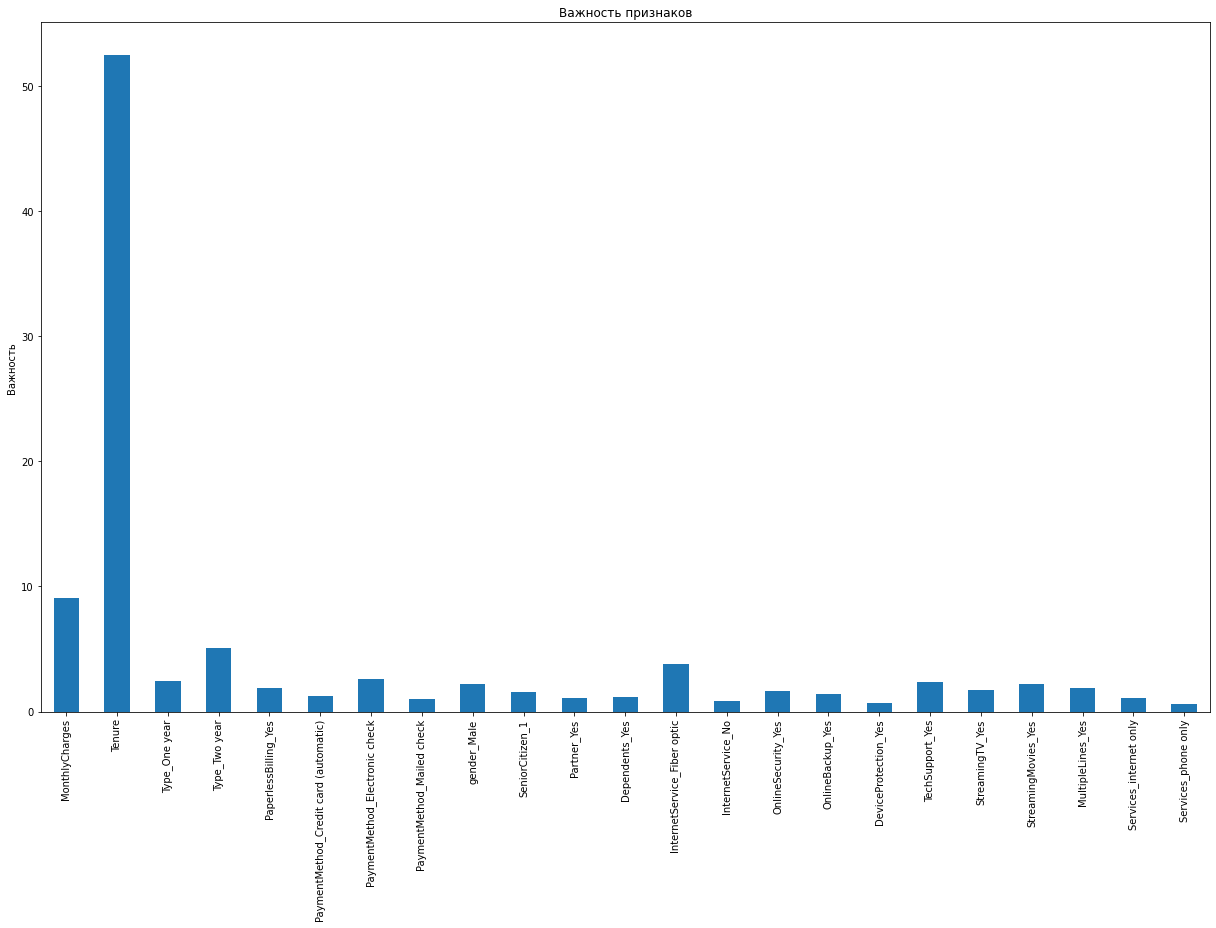

In [53]:
feature_importance_model_3 = pd.Series(model_3.feature_importances_,
                         features_train.columns)

fig, ax = plt.subplots(figsize=(17,13))
feature_importance_model_3.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

## Выводы:

Были построены модели способные предсказывать с точностью до 86% и метрикой roc-auc 0,90. Лучший результат показала модель номер 3 - КатБустинг, без балансировки классов методом увеличения выборки.

Также после анализа графика важности факторов, можно сделать следующие выводы:

1) Самый важный признак - это длительность договора с клиентом, если клиент только подключился то нужно стимулировать его акциями и промокодами, а потом он привыкает и скорее всего никуда от нас не уйдет. Вот оно наглядное подтверждение выражения - "Привычка вторая натура".

2) Также относительно важными признаками являются тариф, наличие длительных договоров (на два года), способ оптическим подключением и способ оплаты электронным чеком. Остальные признаки менее важны, и можно их не рассматривать.

3) Отдельно хочется обратить внимание на способ подключения людей через оптику, с него клиенты почему то предпочитают уходить, возможно стоит проверить качество данной услуги.

## Отчет:

Все пункты плана были выполнены, единственное я изначально не учел что у нас большая часть признаков категориальные и корреляция Пирсона не совсем подходит для рассмотрения таких данных. 

Также были трудности с определением ключевого, как выяснилось, признака - длительности подключения, и в итоге длительность подключения договора с клиентом пришлось измерять в днях для увеличения метрики модели, а не в месяцах как было запланировано изначально.

Ключевыми шагами был анализ и предобработка данных, потому что результаты обучения модели в большей степени зависит именно от них.

Итоговая модель с лучшими показателями - это модель КатБустинга, она предсказывает с точностью(accuracy) до 86% и метрикой roc-auc 0,90. Считаю что задание успешно выполнено на максимальные 6 баллов.

Однако хочу обратить внимание на тот момент про который задавал вопросы после первичного анализа и на самой встрече - в наших данных все люди уходят строго в определенные 4 месяца, и возможно за счет этого у нас сильно искажаются данные о длительности подключения, а при полных данных без подобных аномалий, модель может работать хуже. Тем не менее задачу которую перед нами поставил заказчик мы выполнили. 